In [81]:
#https://www.kaggle.com/datasets/carrie1/ecommerce-data

**Import Libraries**

In [82]:
# Step 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

**Load the dataset**

In [83]:
# Step 2: Load dataset
df = pd.read_csv('data.csv', encoding='latin-1')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


**Handle missing values**

In [84]:
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


In [85]:
df = df.dropna(subset=['CustomerID'])
df['CustomerID'] = df['CustomerID'].astype(int)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

/tmp/ipython-input-85-2613567002.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CustomerID'] = df['CustomerID'].astype(int)
/tmp/ipython-input-85-2613567002.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


In [86]:
# Remove cancellations & negative quantities
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]
df = df[df['Quantity'] > 0]

In [87]:
# Step 3: Identify first and last purchase per customer
first_purchase = df.groupby('CustomerID').apply(lambda x: x.nsmallest(1, 'InvoiceDate')).reset_index(drop=True)
last_purchase_date = df.groupby('CustomerID')['InvoiceDate'].max().reset_index()
last_purchase_date.columns = ['CustomerID', 'LastPurchase']

/tmp/ipython-input-87-2471715824.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  first_purchase = df.groupby('CustomerID').apply(lambda x: x.nsmallest(1, 'InvoiceDate')).reset_index(drop=True)


In [88]:
# Step 4: Merge to calculate repeat purchase label
first_purchase = first_purchase.merge(last_purchase_date, on='CustomerID', how='left')
first_purchase['Purchased'] = (first_purchase['InvoiceDate'] < first_purchase['LastPurchase']).astype(int)

**Feature Engineering**

In [89]:
# Step 5: Feature Engineering (based only on first purchase)
first_purchase['Hour'] = first_purchase['InvoiceDate'].dt.hour
first_purchase['DayOfWeek'] = first_purchase['InvoiceDate'].dt.dayofweek

features = first_purchase[['Quantity', 'UnitPrice', 'Hour', 'DayOfWeek', 'Country']]
target = first_purchase['Purchased']

# One-hot encode country
features = pd.get_dummies(features, columns=['Country'], drop_first=True)

**Training**

In [90]:
# Step 6: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)

In [91]:
# Step 7: Train Decision Tree
clf = DecisionTreeClassifier(max_depth=6, random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, random_state=42)

**Evaluating the model**

In [92]:
# Step 8: Evaluation
y_pred = clf.predict(X_test)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

cv_scores = cross_val_score(clf, features, target, cv=5)
print("Cross-validated scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

Confusion Matrix:
 [[ 14 285]
 [ 13 556]]

Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.05      0.09       299
           1       0.66      0.98      0.79       569

    accuracy                           0.66       868
   macro avg       0.59      0.51      0.44       868
weighted avg       0.61      0.66      0.55       868

Accuracy Score: 0.6566820276497696
Cross-validated scores: [0.63824885 0.65092166 0.63940092 0.65092166 0.65051903]
Mean CV Accuracy: 0.6460024237398944


**Feature Importance**

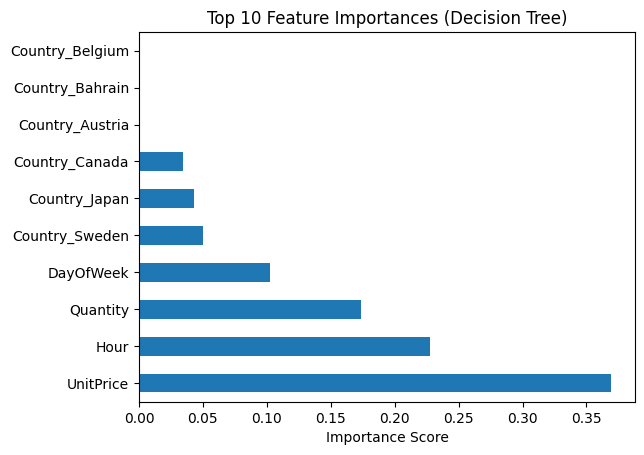

In [93]:
# Step 9: Feature Importance
importances = pd.Series(clf.feature_importances_, index=features.columns)
importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Feature Importances (Decision Tree)")
plt.xlabel("Importance Score")
plt.show()

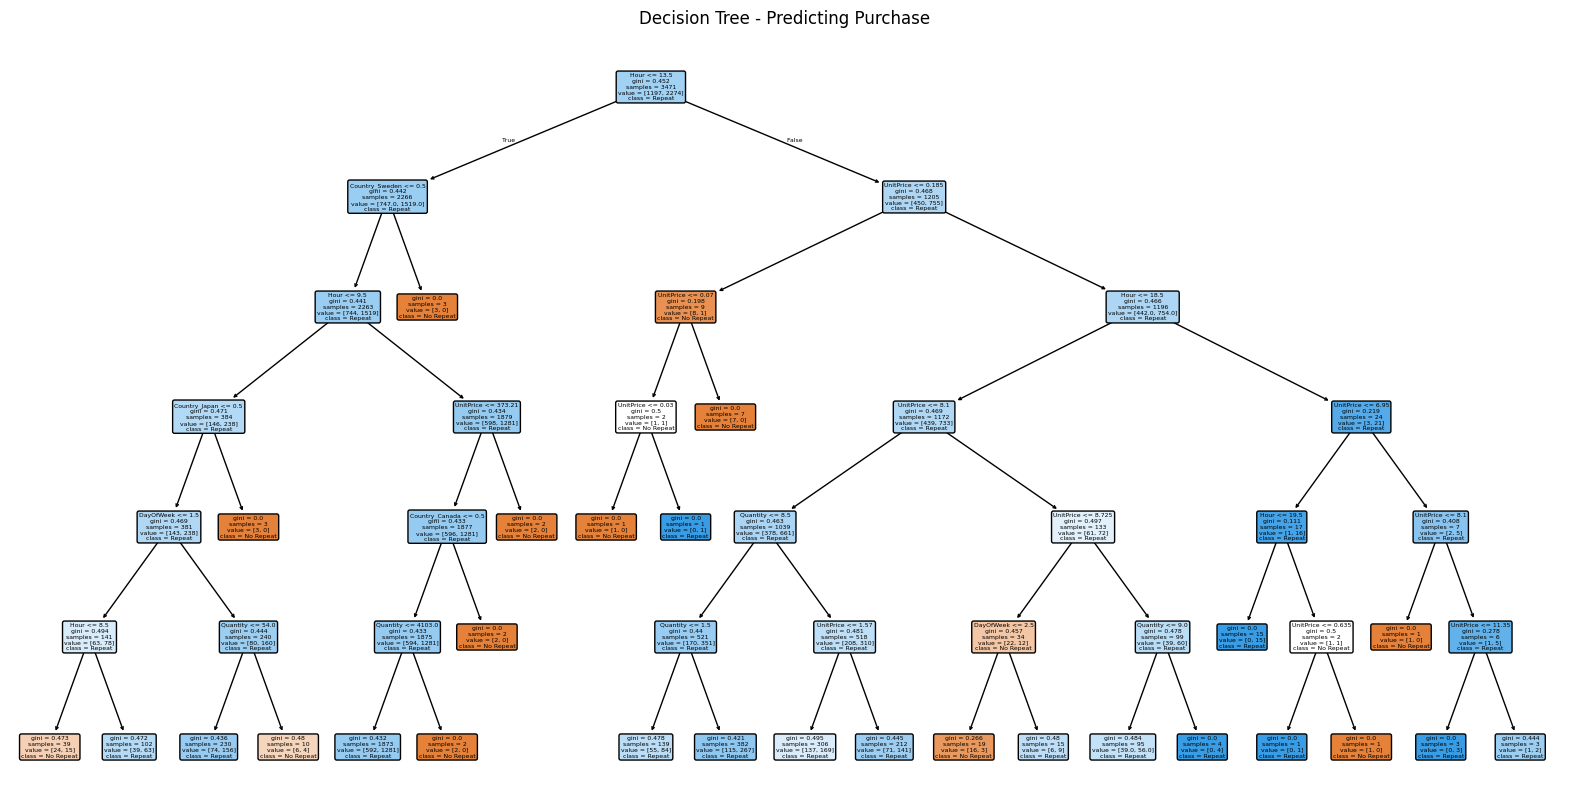

In [94]:
# Step 10: Visualize Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(clf, feature_names=features.columns, class_names=["No Repeat", "Repeat"], filled=True, rounded=True)
plt.title("Decision Tree - Predicting Purchase")
plt.show()